In [1]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import os
import sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv
import torch_geometric.transforms as T
from transformers import AutoConfig, AutoTokenizer, AutoModel
from sklearn import metrics

import warnings

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### SETTNGS

In [2]:
DATA_PATH = "/Users/gufran/Developer/Projects/AI/RadiologyTextToImage/data/"
LOGS_PATH = "/Users/gufran/Developer/Projects/AI/RadiologyTextToImage/logs"
MODEL_PATH = "/Users/gufran/Developer/Projects/AI/RadiologyTextToImage/models"

if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [18]:
MODES = {
    "train": 0,
    "test": 1,
}

In [3]:
seed = 42

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#FOR MAC --------------------------------------------
torch.mps.manual_seed(seed)
torch.backends.mps.deterministic=True
torch.backends.mps.benchmark = False

#FOR WINDOWS AND LINUX -------------------------------
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic=True #replace mps with cudnn here
# torch.backends.cudnn.benchmark = False #replace mps with cudnn here

In [4]:
HIDDEN_SIZE = 200
BERT_HIDDEN_SIZE = 768
OUT_CHANNELS = 20
EPOCHS = 10

In [5]:
device = torch.device("mps")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DATA LOADING AND PREPROCESSING

In [23]:
def load_node_mapping(df, offset):
    node_mapping = {}
    for i, row in df.iterrows():
        node_mapping[row["ID"]] = i + offset
    
    return node_mapping

def load_edge_list(df_cui, cui_node_mapping, caption_node_mapping):
    edge_list = []

    for i, row in df_cui.iterrows():
        cuis = row["CUIs"].split(";")
        cuis = [cui for cui in cuis if cui in cui_node_mapping]

        for cui in cuis:
            edge_list.append([cui_node_mapping[cui], caption_node_mapping[row["ID"]]])
            edge_list.append([caption_node_mapping[row["ID"]], cui_node_mapping[cui]])

    edge_list = sorted(edge_list, key=lambda x: x[0])
    return edge_list

def initialize_data(df_cui_mapping_path, df_cui_path, df_caption_path, num_samples=None):
    config = AutoConfig.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
    tokenizer = AutoTokenizer.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
    radbert = AutoModel.from_pretrained('zzxslp/RadBERT-RoBERTa-4m', config=config)

    df_cui = pd.read_csv(df_cui_path)
    df_cui_mapping = pd.read_csv(df_cui_mapping_path)
    df_caption = pd.read_csv(df_caption_path)

    df_cui_mapping = df_cui_mapping.rename(columns={"CUI": "ID"})

    if num_samples is not None:
        df_caption = df_caption.sample(n=num_samples, random_state=seed).reset_index(drop=True)
        df_cui = df_cui[df_cui["ID"].isin(df_caption["ID"])].reset_index(drop=True)


    #GET CUI AND CAPTION NODE MAPPING
    cui_node_mapping = load_node_mapping(df_cui_mapping, 0)
    caption_node_mapping = load_node_mapping(df_caption, len(cui_node_mapping))
    edge_list = load_edge_list(df_cui, cui_node_mapping, caption_node_mapping)


    #GENERATE NODE FEATURES
    node_features = []

    for cui in tqdm(cui_node_mapping.keys(), desc="Generating node features for CUIs"):
        inputs = tokenizer(df_cui_mapping.loc[df_cui_mapping["ID"] == cui, "Canonical name"][len(node_features)], return_tensors="pt", max_length=128, truncation=True, padding="max_length")
        outputs = radbert(**inputs)
        node_features.append(outputs.last_hidden_state[:, 0, :].detach().numpy())
    for _, row in tqdm(df_caption.iterrows(), total=df_caption.shape[0], desc="Generating node features for captions"):
        caption = row["Caption"]
        inputs = tokenizer(caption, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
        outputs = radbert(**inputs)
        node_features.append(outputs.last_hidden_state[:, 0, :].detach().numpy())

    node_features = np.vstack(node_features)


    #INITIALIZE DATA
    data = Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    )
    data.num_nodes = len(cui_node_mapping) + len(caption_node_mapping)
    data.num_edges = len(edge_list)

    print("Number of nodes:", data.num_nodes)
    print("Number of edges:", data.num_edges)
    print("Space on disk (data):", sys.getsizeof(data) / 1024 / 1024, "MB")
    print("Space on disk (node features):", sys.getsizeof(node_features) / 1024 / 1024, "MB")
    print("Space on disk (edge list):", sys.getsizeof(edge_list) / 1024 / 1024, "MB")
    print()

    return data

data = initialize_data(
    os.path.join(DATA_PATH, "rocov2", "cui_mapping.csv"),
    os.path.join(DATA_PATH, "rocov2", "train_concepts.csv"),
    os.path.join(DATA_PATH, "rocov2", "train_captions.csv"),
    num_samples=5000
)

Some weights of RobertaModel were not initialized from the model checkpoint at zzxslp/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating node features for captions: 100%|██████████| 5000/5000 [02:51<00:00, 29.15it/s]


Number of nodes: 6934
Number of edges: 33050
Space on disk (data): 5.340576171875e-05 MB
Space on disk (node features): 20.3145751953125 MB
Space on disk (edge list): 0.25220489501953125 MB



In [7]:
data.validate(raise_on_error=True)

True

In [8]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.15, num_test=0, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset, val_dataset, _ = transform(data)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)

Train Data:
 Data(x=[6934, 768], edge_index=[2, 28094], num_nodes=6934, num_edges=33050, pos_edge_label=[14047], pos_edge_label_index=[2, 14047], neg_edge_label=[14047], neg_edge_label_index=[2, 14047])
Validation Data:
 Data(x=[6934, 768], edge_index=[2, 28094], num_nodes=6934, num_edges=33050, pos_edge_label=[2478], pos_edge_label_index=[2, 2478], neg_edge_label=[2478], neg_edge_label_index=[2, 2478])


### HELPER FUNCTIONS

In [9]:
def plot_roc_curve(model, data):
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [10]:
def plot_training_stats(title, val_auc, val_ap, train_auc, train_ap):
  fig, ax = plt.subplots()

  ax.set_xlabel("Training Epochs")
  ax.set_ylabel("AUC/AP")

  plt.title(title)
  p1, = ax.plot(val_auc, "r-", label="val AUC")
  p2, = ax.plot(val_ap, "g-", label="val AP")
  p3, = ax.plot(train_auc, "o-", label="train AUC")
  p4, = ax.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4])
  plt.show()

### MODEL ARCHITECTURE

In [11]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)

gcn_encoder = GCNEncoder(BERT_HIDDEN_SIZE, HIDDEN_SIZE, OUT_CHANNELS, 0.5)
gae_model = GAE(gcn_encoder)
gae_model = gae_model.to(device)

### TRAINING

In [12]:
def train_step(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)

In [13]:
losses = []
val_auc = []
val_ap = []
train_aucs = []
train_aps = []

optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)
for epoch in range(1, EPOCHS + 1):
    loss = train_step(train_dataset, gae_model, optimizer)
    losses.append(loss)

    train_auc, train_ap = test(train_dataset, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    auc, ap = test(val_dataset, gae_model)
    val_auc.append(auc)
    val_ap.append(ap)

    print('Epoch: {:03d}, val AUC: {:.4f}, val AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, val AUC: 0.9060, val AP: 0.9255, train AUC: 0.9446, train AP: 0.9456, loss:1.6932
Epoch: 002, val AUC: 0.9067, val AP: 0.9257, train AUC: 0.9451, train AP: 0.9458, loss:1.7146
Epoch: 003, val AUC: 0.9069, val AP: 0.9258, train AUC: 0.9453, train AP: 0.9459, loss:1.7843
Epoch: 004, val AUC: 0.9082, val AP: 0.9264, train AUC: 0.9461, train AP: 0.9463, loss:1.9906
Epoch: 005, val AUC: 0.9095, val AP: 0.9270, train AUC: 0.9469, train AP: 0.9466, loss:2.0345
Epoch: 006, val AUC: 0.9109, val AP: 0.9276, train AUC: 0.9476, train AP: 0.9469, loss:1.9278
Epoch: 007, val AUC: 0.9124, val AP: 0.9281, train AUC: 0.9483, train AP: 0.9470, loss:1.8407
Epoch: 008, val AUC: 0.9134, val AP: 0.9284, train AUC: 0.9488, train AP: 0.9470, loss:1.7893
Epoch: 009, val AUC: 0.9140, val AP: 0.9284, train AUC: 0.9490, train AP: 0.9469, loss:1.7780
Epoch: 010, val AUC: 0.9142, val AP: 0.9284, train AUC: 0.9491, train AP: 0.9468, loss:1.7818


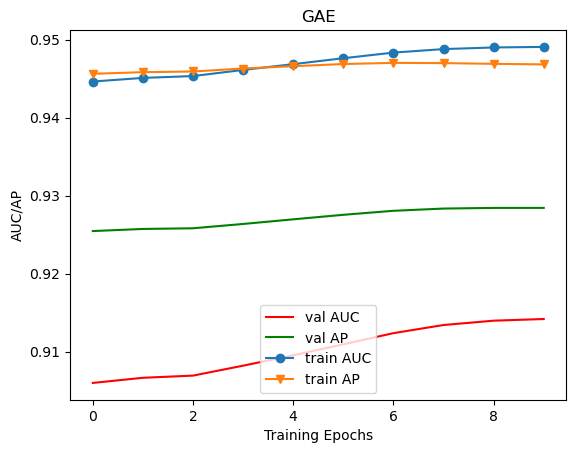

In [14]:
plot_training_stats('GAE', val_auc, val_ap, train_aucs, train_aps)

Best Threshold=0.579815


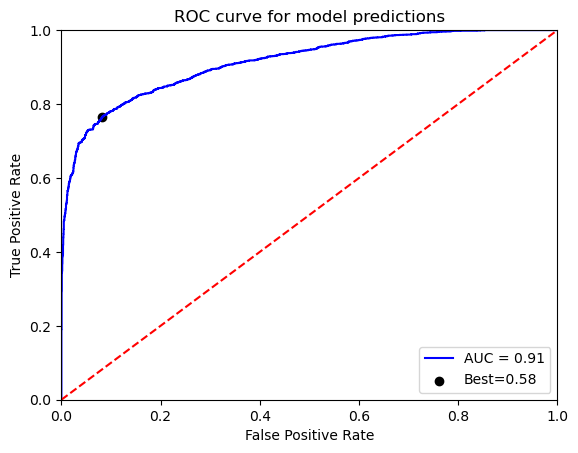

In [15]:
plot_roc_curve(gae_model, val_dataset)

### TESTING

In [22]:
test_data = initialize_data(
    os.path.join(DATA_PATH, "rocov2", "cui_mapping.csv"),
    os.path.join(DATA_PATH, "rocov2", "test_concepts.csv"),
    os.path.join(DATA_PATH, "rocov2", "test_captions.csv"),
)

transform_test = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,split_labels=True, add_negative_train_samples=True),
])
test_dataset, _, _ = transform_test(data)

Some weights of RobertaModel were not initialized from the model checkpoint at zzxslp/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating node features for captions: 100%|██████████| 9972/9972 [05:42<00:00, 29.07it/s]


Number of nodes: 11906
Number of edges: 67532
Space on disk (data): 5.340576171875e-05 MB
Space on disk (node features): 34.8809814453125 MB
Space on disk (edge list): 0.5152816772460938 MB



In [28]:
auc, ap = test(test_dataset.to(device), gae_model)
print("Test AUC:", auc)
print("Test AP:", ap)

Test AUC: 0.9429353883196276
Test AP: 0.9431333329400058


### SAVE THE ENCODER

In [35]:
test_data

Data(x=[11906, 768], edge_index=[0], num_nodes=11906, num_edges=67532)

In [33]:
test_dataset

Data(x=[6934, 768], edge_index=[2, 33050], num_nodes=6934, num_edges=33050, pos_edge_label=[16525], pos_edge_label_index=[2, 16525], neg_edge_label=[16525], neg_edge_label_index=[2, 16525])

In [18]:
#save encoder model
# torch.save(gae_model.encoder.state_dict(), os.path.join(MODEL_PATH, "text_encoder.pth"))